<a href="https://colab.research.google.com/github/senkmp/titanic-tf.keras/blob/master/Tutorial_titanic_problem_tf_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train tf.keras model using feature coulmns 

In this tutorial, we will see how to use tf.keras model to classify structured data (pandas dataframe)  with creating an input pipe line using feature columns ( tf.feature_column) and tf.data.

you will learn-


* Creating different types of feature columns using tf.feature_columns
* Creating input data function using tf.data for train, val and test set
* Creating, compiling and training of tf.keras.model 
* Evaluating model
* Prediction on test data

## The Dataset

I have used [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview) from kaggle, you can [download](https://www.kaggle.com/c/3136/download-all) and find [description](https://www.kaggle.com/c/titanic/data) of dataset on kaggle. I have used google colab and hence uploaded data in google drive.

## Mount google drive
I have uploaded data on **google drive,** Learn How to use data from google drive [here](https://medium.com/ml-book/simplest-way-to-open-files-from-google-drive-in-google-colab-fae14810674)

---

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import TensorFlow and other libraries
I have used Tensorflow nightly version which is unstable version (aug 2019)

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly-gpu-2.0-preview
except Exception:
  pass



!pip install sklearn
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
print("GPU Available: ", tf.test.is_gpu_available())

GPU Available:  True


# Load and preprocess Data

## Use Pandas to create a dataframe

[Pandas](https://pandas.pydata.org/) is a Python library with many helpful utilities for loading and working with structured data. We will use Pandas to download the dataset from mounted google drive, and load it into a dataframe

In [0]:
data = pd.read_csv('drive/My Drive/collab data/titanic/train.csv')
data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [0]:
data.shape

(891, 12)

## Missing Data

### Check missing values

In [0]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Missing value handling

As you can seee that there are some missing values in 'age' , 'embark' and 'cabin'. In 'cabin' number of missing values are large hence we delete this column from data, and in 'age' we will fill missing values with mean value and in 'embark' with most frequent value.

In [0]:
mean_value = round(data['Age'].mean())
mode_value = data['Embarked'].mode()[0]

value = {'Age': mean_value, 'Embarked': mode_value}
data.fillna(value=value,inplace=True)

data.dropna(axis=1,inplace=True)

In [0]:
data.shape

(891, 11)

## Explore data with pandas_profiling library 

In [0]:
import pandas_profiling as pdpf

In [0]:
pdpf.ProfileReport(data)

Number of variables,11
Number of observations,891
Total Missing (%),0.0%
Total size in memory,76.6 KiB
Average record size in memory,88.1 B
Numeric,6
Categorical,3
Boolean,1
Date,0
Text (Unique),1
Rejected,0


# Train, val, test Split

We will divide data into train, validation, test data with 3:1:1 ratio

In [0]:
train, test = train_test_split(data, test_size=0.2)
train, val = train_test_split(train, test_size=0.25)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

534 train examples
178 validation examples
179 test examples


# Input pilpe line

## Create an input pipeline using tf.data

Next, we will wrap the dataframes with [tf.data](https://www.tensorflow.org/guide/datasets). This will enable us  to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. If we were working with a very large CSV file (so large that it does not fit into memory), we would use tf.data to read it from disk directly. That is not covered in this tutorial.

In [0]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Survived')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [0]:
batch_size = 32 
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

## Understand the input pipeline

Now that we have created the input pipeline, let's call it to see the format of the data it returns. We have used a small batch size to keep the output readable.

In [0]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of ages:', feature_batch['Age'])
  print('A batch of targets:', label_batch )

Every feature: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']
A batch of ages: tf.Tensor(
[60.   30.   17.   18.   30.   30.   30.   48.   53.   30.   31.   22.
 40.5  23.   17.   18.   50.   30.    3.    9.   14.   36.   52.    0.83
 30.   33.    6.   33.   15.   27.   30.   34.  ], shape=(32,), dtype=float32)
A batch of targets: tf.Tensor([0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1], shape=(32,), dtype=int32)


We can see that the dataset returns a dictionary of column names (from the dataframe) that map to column values from rows in the dataframe.

## Feature columns

Know more about feature columns [here](https://medium.com/ml-book/demonstration-of-tensorflow-feature-columns-tf-feature-column-3bfcca4ca5c4) 

### Decide which types of features you have in data
While data exploration you should note the types of features we have, for example, whether a feature is numerical or categorical, if it is numerical then can we categorize it into buckets or not, or if it is categorical then it should be checked how many categories are there, can we convert it into indicator columns or embedding column, are there any two feature, those can we combined to create new crossed feature. I will recommend you to read this very simplified [tutorial on feature columns](https://medium.com/ml-book/demonstration-of-tensorflow-feature-columns-tf-feature-column-3bfcca4ca5c4).

In [0]:
#numarical features
num_c = ['Age','Fare','Parch','SibSp'] 
bucket_c  = ['Age'] #bucketized numerical feature

#categorical features
cat_i_c = ['Embarked', 'Pclass','Sex'] #indicator columns
cat_e_c = ['Ticket'] # embedding column

### Scaler function
It is very important for numerical variables to get scaled. here I have used min-max scaling. Here we are creating a function named 'get_scal' which takes list of numerical features and  returns 'minmax' function, which will be used in tf.feature_column.numeric_column() as normalizer_fn in parameters. 'minmax' function itself takes a 'numerical' number from a particular feature and return scaled value of that number. 

In [0]:
def get_scal(feature):
  def minmax(x):
    mini = train[feature].min()
    maxi = train[feature].max()
    return (x - mini)/(maxi-mini)
  return(minmax)

### Creating feature columns


#### Numerical Columns

In [0]:
feature_columns = []
for header in num_c:
  scal_input_fn = get_scal(header)
  feature_columns.append(feature_column.numeric_column(header, normalizer_fn=scal_input_fn))

#### Bucketized columns

In [0]:
Age = feature_column.numeric_column("Age")
# bucketized cols
age_buckets = feature_column.bucketized_column(Age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

#### Categorical Indicator columns

In [0]:
for feature_name in cat_i_c:
  vocabulary = data[feature_name].unique()
  cat_c = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)
  one_hot = feature_column.indicator_column(cat_c)
  feature_columns.append(one_hot)

#### Categorical Embedding columns

In [0]:
for feature_name in cat_e_c:
  vocabulary = data[feature_name].unique()
  cat_c = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)
  embeding = feature_column.embedding_column(cat_c, dimension=50)
  feature_columns.append(embeding)

#### Crosed columns
Combination of 'age' (age buckets) and 'sex'

In [0]:
vocabulary = data['Sex'].unique()
Sex = tf.feature_column.categorical_column_with_vocabulary_list('Sex', vocabulary)

crossed_feature = feature_column.crossed_column([age_buckets, Sex], hash_bucket_size=1000)
crossed_feature = feature_column.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

In [0]:
print('Total number of feature coumns: ',len(feature_columns))

Total number of feature coumns:  10


# Create, compile and train the model

### Create a feature layer
Now that we have defined our feature columns, we will use a [DenseFeatures](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/DenseFeatures) layer to input them to our Keras model.

In [0]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

#### tf.keras

In [0]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu'),
  layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu'),
  layers.Dropout(0.2),
  
  layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=20)

Epoch 1/20
17/17 [==============================] - 2s 101ms/step - loss: 1.1437 - accuracy: 0.6348 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
17/17 [==============================] - 0s 14ms/step - loss: 0.9583 - accuracy: 0.6348 - val_loss: 0.8858 - val_accuracy: 0.5843
Epoch 3/20
17/17 [==============================] - 0s 15ms/step - loss: 0.8232 - accuracy: 0.6854 - val_loss: 0.7810 - val_accuracy: 0.6798
Epoch 4/20
17/17 [==============================] - 0s 14ms/step - loss: 0.7309 - accuracy: 0.7659 - val_loss: 0.7018 - val_accuracy: 0.7753
Epoch 5/20
17/17 [==============================] - 0s 14ms/step - loss: 0.6384 - accuracy: 0.8408 - val_loss: 0.6382 - val_accuracy: 0.8090
Epoch 6/20
17/17 [==============================] - 0s 14ms/step - loss: 0.5673 - accuracy: 0.8596 - val_loss: 0.5900 - val_accuracy: 0.8146
Epoch 7/20
17/17 [==============================] - 0s 16ms/step - loss: 0.4705 - accuracy: 0.8989 - val_loss: 0.5641 - val_accuracy: 0.8315
Epoc

# Evaluation

In [0]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy: ", accuracy)

6/6 [==============================] - 0s 70ms/step - loss: 0.6719 - accuracy: 0.7877
Accuracy:  0.7877095


## Train vs Val 'accuracy' and 'loss'

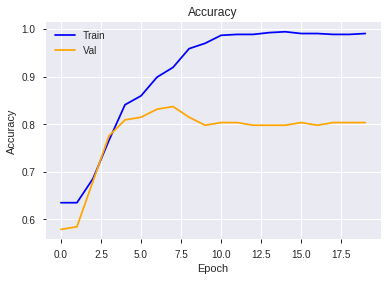

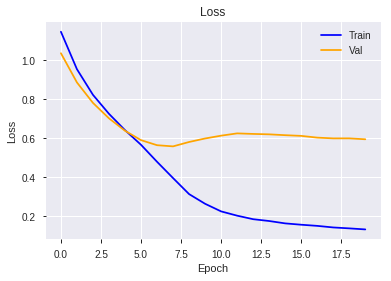

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(20)

plt.title('Accuracy')
plt.plot(epochs,  history.history['accuracy'], color='blue', label='Train')
plt.plot(epochs, history.history['val_accuracy'], color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Loss')
plt.plot(epochs, history.history['loss'], color='blue', label='Train')
plt.plot(epochs, history.history['val_loss'], color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Problem Test Data

## Load and preprocess test data

In [0]:
test_data = pd.read_csv('drive/My Drive/collab data/titanic/test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [0]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [0]:
mean_value = round(data['Age'].mean())
mean_value1 = data['Fare'].mean()

value = {'Age': mean_value, 'Fare': mean_value1}
test_data.fillna(value=value,inplace=True)

In [0]:
test_data.dropna(axis=1,inplace=True)

## Input function for test data

In [0]:
def test_input_fn(features, batch_size=256):
    """An input function for prediction."""
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

In [0]:
test_predict = test_input_fn(dict(test_data))

## Prediction 
Predicting proability 

In [0]:
predicted_ar=model.predict(test_predict)

### Prediction DataFrame

In [0]:
predict_df = test_data[['PassengerId']]
predict_df['Survived'] = predicted_ar
predict_df['Survived'] = predict_df['Survived'].apply(lambda x: 1 if x>=.5 else 0) #converting probability into class
predict_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# End